### Import third-party packages

In [1]:
import torch
import torch.nn as nn
import loralib as lora
from model import CNN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import optuna
import json
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, max_error
import matplotlib.pyplot as plt
# Determine the equipment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters tuning of LoRA-CT method

In [4]:

# Modifying the primary model architecture
def get_peft_model(base_model, lora_rank, lora_alpha):
    np.random.seed(42)
    torch.manual_seed(42)
    class PeftModel(nn.Module):
        def __init__(self, base_model, lora_rank, lora_alpha):
            super(PeftModel, self).__init__()
            for name, module in base_model.named_children():
                if name != 'Linear':
                    self.add_module(name, module)
                else:
                    self.add_module(name, lora.Linear(base_model.Linear.in_features, base_model.Linear.out_features, r=lora_rank, lora_alpha=lora_alpha, merge_weights=True))
            
        def forward(self, x):
            for module in self.children():
                x = module(x)
            return x.squeeze(dim=1)
    
    return PeftModel(base_model, lora_rank, lora_alpha)

def opt_model(trial):
    np.random.seed(42)
    torch.manual_seed(42)
    # Hyperparameter definitions
    learning_rate = trial.suggest_categorical("Learning rate", [1e-5, 1e-4, 1e-3, 1e-2])
    weight_decay = trial.suggest_categorical("Regularization coefficient", [1e-3, 1e-2, 1e-1])
    lora_rank = trial.suggest_categorical("Lora rank", [2, 4, 6, 8])
    lora_alpha = lora_rank 

    Path2 = 'iRaman-Methanol-data\\interpolated_iRaman.csv'
    X = pd.read_csv(Path2, header=None, index_col=0)
    X = np.array(X)
    X = X.T
    
    y_path = 'iRaman-Methanol-data\\Raman-Quantitative labels.csv'
    y = pd.read_csv(y_path, header=None)
    y = np.array(y)
    y = y.reshape(-1)
    
    X_trans, X_val, y_trans, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    X_train, X_left, y_train, y_left = train_test_split(X_trans, y_trans, test_size=0.95, random_state=40)
    

    
    # Convert data to tensor and make sure it's on the right device
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=len(y_train), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(y_val), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(y_test), shuffle=False)

    # Load pre-trained model
    model_state_dict = torch.load('Methanol_best_model_cnn_x1.pt', map_location=device, weights_only=True)
    base_model = CNN()
    peft_model = get_peft_model(base_model, lora_rank, lora_alpha).to(device)
    peft_model.load_state_dict(model_state_dict, strict=False)
    
    # Perform weight decay
    original_weight = peft_model.Linear.weight.data
    decayed_weight = original_weight * 0.5
    peft_model.Linear.weight.data = decayed_weight
    #Confirm the layers to be trained
    lora.mark_only_lora_as_trainable(peft_model)

    optimizer = torch.optim.AdamW(peft_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.SmoothL1Loss().to(device)
    epochs = 100

    for epoch in range(epochs):
        peft_model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            outputs = peft_model(batch_x)
            loss = loss_fn(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    peft_model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            output = peft_model(batch_x)
            predictions.extend(output.cpu().tolist())
            actuals.extend(batch_y.cpu().tolist())

    if len(predictions) >= 2:
        r2 = r2_score(actuals, predictions)
    return r2

# hyperparameters tuning
study = optuna.create_study(direction="maximize")
study.optimize(opt_model, n_trials=50)
print('Optimal hyperparameter results:', study.best_params)

# Save the best hyperparameters
best_params = study.best_params
with open('lora_peft_best_hyperparameters_5%.json', 'w') as f:
    json.dump(best_params, f)

[I 2025-02-17 18:55:27,847] A new study created in memory with name: no-name-94cad3e2-0495-4961-9437-96c0de491185
[I 2025-02-17 18:55:29,693] Trial 0 finished with value: 0.9576030907021048 and parameters: {'Learning rate': 0.0001, 'Regularization coefficient': 0.1, 'Lora rank': 8}. Best is trial 0 with value: 0.9576030907021048.
[I 2025-02-17 18:55:30,360] Trial 1 finished with value: 0.4964110959491379 and parameters: {'Learning rate': 1e-05, 'Regularization coefficient': 0.01, 'Lora rank': 8}. Best is trial 0 with value: 0.9576030907021048.
[I 2025-02-17 18:55:30,980] Trial 2 finished with value: 0.4964110959491379 and parameters: {'Learning rate': 1e-05, 'Regularization coefficient': 0.01, 'Lora rank': 8}. Best is trial 0 with value: 0.9576030907021048.
[I 2025-02-17 18:55:31,569] Trial 3 finished with value: 0.9661275336656268 and parameters: {'Learning rate': 0.001, 'Regularization coefficient': 0.001, 'Lora rank': 4}. Best is trial 3 with value: 0.9661275336656268.
[I 2025-02-17

Optimal hyperparameter results: {'Learning rate': 0.01, 'Regularization coefficient': 0.001, 'Lora rank': 8}


### Load the optimal combination of hyperparameters of the LoRA-CT method for fine-tuned training

Epoch 1, Train Loss: 0.01781589537858963, Val Loss: 0.04447930306196213
Epoch 2, Train Loss: 0.011382244527339935, Val Loss: 2.3336639404296875
Epoch 3, Train Loss: 3.660041332244873, Val Loss: 0.023819662630558014
Epoch 4, Train Loss: 0.08227641135454178, Val Loss: 0.5277799963951111
Epoch 5, Train Loss: 0.7760681509971619, Val Loss: 0.08994593471288681
Epoch 6, Train Loss: 0.06854035705327988, Val Loss: 0.6826598048210144
Epoch 7, Train Loss: 1.2974045276641846, Val Loss: 0.8876872062683105
Epoch 8, Train Loss: 1.5846445560455322, Val Loss: 0.268945574760437
Epoch 9, Train Loss: 0.6021087169647217, Val Loss: 0.060355424880981445
Epoch 10, Train Loss: 0.03540396690368652, Val Loss: 0.36928415298461914
Epoch 11, Train Loss: 0.507777214050293, Val Loss: 0.3705298900604248
Epoch 12, Train Loss: 0.5120118856430054, Val Loss: 0.1615431010723114
Epoch 13, Train Loss: 0.19264520704746246, Val Loss: 0.03327549993991852
Epoch 14, Train Loss: 0.018197232857346535, Val Loss: 0.010218668729066849

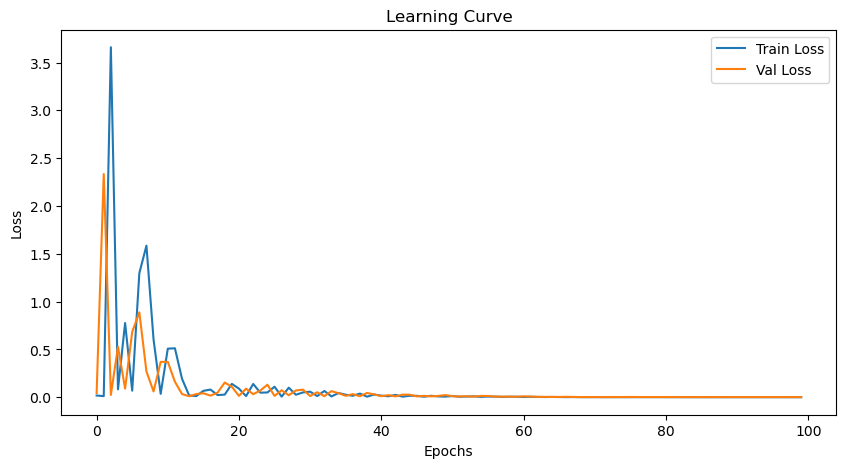

Training set evaluation results:
R2: 0.9980168733057618, RMSEP: 0.007351204166578705, MAE: 0.005698628723621368, MAX_ERROR: 0.010462909936904907
Validation set evaluation results:
R2: 0.9736713521463051, RMSEP: 0.04629299603635504, MAE: 0.03877436671367226, MAX_ERROR: 0.07141701132059097
Test set evaluation results:
R2: 0.9544333433600499, RMSEP: 0.07060762319117439, MAE: 0.05854200521627298, MAX_ERROR: 0.16893762350082397


In [5]:


def load_data():
    Path2 = 'iRaman-Methanol-data\\interpolated_iRaman.csv'
    X = pd.read_csv(Path2, header=None, index_col=0).values.T
    y_path = 'iRaman-Methanol-data\\Raman-Quantitative labels.csv'
    y = pd.read_csv(y_path, header=None).values.reshape(-1)
    return X, y

def split_data(X, y):
    X_trans, X_val, y_trans, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    X_train, X_left, y_train, y_left = train_test_split(X_trans, y_trans, test_size=0.95, random_state=40)
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=len(y_train), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(y_val), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(y_test), shuffle=False)

    return train_loader, val_loader, test_loader

def get_peft_model(base_model, lora_rank, lora_alpha):
    class PeftModel(nn.Module):
        np.random.seed(42)
        torch.manual_seed(42)
        def __init__(self, base_model, lora_rank, lora_alpha):
            super(PeftModel, self).__init__()
            for name, module in base_model.named_children():
                if name != 'Linear':
                    self.add_module(name, module)
                else:
                    self.add_module(name, lora.Linear(base_model.Linear.in_features, base_model.Linear.out_features, r=lora_rank, lora_alpha=lora_alpha, merge_weights=True))
            
        def forward(self, x):
            for module in self.children():
                x = module(x)
            return x.squeeze(dim=1)
    
    return PeftModel(base_model, lora_rank, lora_alpha)

def train_model(model, train_loader, val_loader, learning_rate, weight_decay):
    model.to(device)
    loss_fn = nn.SmoothL1Loss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    epochs = 100
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.unsqueeze(dim=1).to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = loss_fn(output, batch_y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')
    
    return train_losses, val_losses

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            predictions.extend(output.cpu().tolist())
            actuals.extend(batch_y.cpu().tolist())
    final_r2 = r2_score(actuals, predictions)
    RMSEP = root_mean_squared_error(actuals, predictions)
    MAE = mean_absolute_error(actuals, predictions)
    MAX_ERROR = max_error(actuals, predictions)
    return final_r2, RMSEP, MAE, MAX_ERROR

def save_model(model, filename):
    torch.save(model.state_dict(), filename)


def main():
    with open('lora_peft_best_hyperparameters_5%.json', 'r') as f:
        best_params = json.load(f)
    
    learning_rate = best_params['Learning rate']
    weight_decay = best_params['Regularization coefficient']
    lora_rank = int(best_params['Lora rank'])
    lora_alpha = lora_rank
    np.random.seed(42)
    torch.manual_seed(42)
    X, y = load_data()
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)
    
    base_model = CNN()
    peft_model = get_peft_model(base_model, lora_rank, lora_alpha)

    model_state_dict = torch.load('Methanol_best_model_cnn_x1.pt', map_location=device, weights_only=True)
    peft_model.load_state_dict(model_state_dict, strict=False)
    # Perform weight decay
    original_weight = peft_model.Linear.weight.data
    decayed_weight = original_weight * 0.5
    peft_model.Linear.weight.data = decayed_weight

    lora.mark_only_lora_as_trainable(peft_model)

    peft_model = peft_model.to(device)
    train_losses, val_losses = train_model(peft_model, train_loader, val_loader,learning_rate, weight_decay)
    plot_learning_curve(train_losses, val_losses)

    print('Training set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, train_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')

    print('Validation set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, val_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')

    print('Test set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, test_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')
    # Save the weights of the lora module
    torch.save(lora.lora_state_dict(peft_model), 'lora_state_dict_5%.pt')
    save_dict = {}
    # Save the weights of the fine-tuned BN layer
    model_state = peft_model.state_dict()
    for k,v in model_state.items():
        if 'BatchNorm' in k:
            save_dict[k] = v
    torch.save(save_dict, 'peft_model_BN_5%.pt')
if __name__ == '__main__':
    main()